![title](yelp2.jpg)
# Smash the Snorkel Team Project: 
# A Weak Supervised Learning Study for Yelp Restaruant Review Classification 
# Part 2

## 0. A connection with part 1
In Part 1 we have hosted a .json file of our collection into a cloud-based DataBase. We extracted from it which businesses are restaurants and then we've splitted our reviews into development, test and training. In this notebook we load these subsets and we perform our main analysis with Snorkel for creating our labels (if a review contain useful suggestions or complaints).
### 0.1 Import required libraries for part 2


In [1]:
#Visualize properly pyspark dataframes
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#Spark NLP imports (text processing in scale)
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.embeddings import *
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.common import RegexRule

# Start Spark Session with Spark NLP
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  2.4.1
Apache Spark version:  2.4.4


In [3]:
#Pyspark 
import pyspark
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import array_contains
from pyspark.ml import Pipeline, PipelineModel

from pyspark.sql import functions as F
from pyspark.sql import SQLContext
sc = pyspark.SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

### 0.2 Import tables from part 1
Below we import all the tables that we have created in part 1. Ideally, if we have performed all the analysis in a single notebook, we could continue using them as pyspark DataFrames.

In [4]:
##DEVELOPMENT SET WITH GOLD LABELS
df_dev = spark.read.csv("/project/EXPROTS/df_dev.csv", escape='"', multiLine=True, inferSchema=True, header=True)
colnames = df_dev.columns
df_dev = df_dev.toDF(*map(str, range(len(colnames))))\
    .drop(str(len(colnames)-1))\
    .toDF(*colnames[:-1])
df_dev = df_dev.withColumnRenamed("label\r", "label")

##VALIDATION SET WITH GOLD LABELS 
review_test = spark.read.csv("/project/EXPROTS/df_test.csv", escape='"', multiLine=True,
     inferSchema=True, header=True)
review_test = review_test.withColumnRenamed("label\r", "label")

##2500 REVIEWS WITHOUT GOLD LABELS
review_train = spark.read.csv("/project/review_train.csv", escape='"', multiLine=True,
     inferSchema=True, header=True)
review_train = review_train.withColumnRenamed("label\r", "label")

In [5]:
#Load all datasets for the restaurants (these files are used in analysis in part 3.2.5)
#Load from existing file
#biz_res.csv = spark.read.csv("/project/filtered_data/biz_rez.csv", escape='"', multiLine=True, inferSchema=True, header=True)
#review_test = review_test.withColumnRenamed("label\r", "label")
#checkin_res = spark.read.csv("/project/filtered_data/checkin_res.csv", escape='"', multiLine=True, inferSchema=True, header=True)
#review_res = spark.read.csv("/project/filtered_data/review_res.csv", escape='"', multiLine=True, inferSchema=True, header=True)
#user_res = spark.read.csv("/project/filtered_data/user_res.csv", escape='"', multiLine=True,  inferSchema=True, header=True)


#OR
#Recreate them from .json files
## Here we use the business.json file to extract some aggregated metrics for the numerical label functions (3.2.5)
biz_df = sqlContext.read.json("original_data/business.json") #It is used for the analysis in 3.2.5
biz_df.createOrReplaceTempView('biz_table')
#only keep restaurants
biz_res = sqlContext.sql('SELECT * FROM biz_table WHERE categories LIKE \'%Restaurants%\'') # Mongo Needed
biz_res.createOrReplaceTempView('biz_res_table')

######
def filter_res(parent,filename,key): #filter the irrelevant records from other table
    df = sqlContext.read.json("original_data/"+filename)
    table_name=filename[:-5]+'_table'
    df.createOrReplaceTempView(filename[:-5]+'_table')
    sqlquery = 'SELECT c.* FROM {} c LEFT JOIN {} b ON c.{} = b.{} WHERE b.{} IS NOT NULL'.format(table_name,parent,key,key,key)
    print(sqlquery)
    df_res=sqlContext.sql(sqlquery)
    return df_res

checkin_res = filter_res('biz_res_table','checkin.json','business_id')
review_res = filter_res('biz_res_table','review.json','business_id')
review_res.createOrReplaceTempView('review_res_table')
#tip_res = filter_res('review_res_table','tip.json','user_id') #since tip is on individual level, match them with users
user_res = filter_res('review_res_table','user.json','user_id')

SELECT c.* FROM checkin_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM review_table c LEFT JOIN biz_res_table b ON c.business_id = b.business_id WHERE b.business_id IS NOT NULL
SELECT c.* FROM user_table c LEFT JOIN review_res_table b ON c.user_id = b.user_id WHERE b.user_id IS NOT NULL


In [6]:
df_dev.show()

+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+
|  #|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+
|  0|XFhnPpO2x0nS-lVkq...|   1|2017-02-14 16:50:06|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1082331766789|      0|    1|
|  1|SRCepG6PbMvwKcfIU...|   0|2015-12-11 02:47:27|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7afssQR...| 730144449129|      1|    1|
|  2|pneBBrIzd3SCbbglY...|   2|2015-05-15 19:18:52|    0|AeyK7AEtbfubw1aD0...|    4|This is a great o...|     4|X4k8ugJaihHVLHq32...| 489626295186|      2|    0|
|  3|8enR8Wc0ot9L41JY1...|  

### 0.3 A refresher into our project:
### Business Problem Identification

The competition between restaurants is fiercer than ever. Restaurant owners are under consistent pressure 
to improve their business or set themselves apart from the rest. But how? Although some restuarants still rely 
on asking their customers directly, more and more restuarants have been leveraging reviews on apps like Yelp 
to understand what their customers need. In this case, the reviews containing complaints/suggestions are invaluable as they 
explicitly point out the possible solution to improving customers' satisfaction.

For restuarants receiving numerous reviews,however, it is hard for the business owners to investigate every review to figure 
out whether the reviews contain useful suggestions/complaints. Therefore, an automatic process is needed to filter irrelevent 
information quickly.


### Project Objective
In this project we seek to automize the classification of reviews to understand whether a review is mentioning complaints or suggestions using **Yelp** review dataset. One extra challenge that lies ahead is that we don't have any datapoint with the "golden" label indicating this piece of  information. 
Consequently, to cope with this problem, we aim to find solution to classification problem without any existing labels.
**Objective**: Find solution for classification problem when there is no pre-exsiting label.


### Key Results
There are four major results in this project.
a) Build a Database hosting the data source to mimic the industrial canon. (Part 1)
b) Create labeling functions using Snorkel DryBell to provide weak supervised-learning at industrial scale.
c) Augment dataset to create more training datapoints
d) Train a classifier for labeling a unseen review automatically. 

### Project Structure
Below you can see a diagram that represents the workflow of the project. This includes the flow of the original files from start to end, and the actions taken in each step of the process. <br><br>
As you can see we have acquired flat files in JSON format from the official yelp website. Then we have uploaded on of the files on the CosmosDB platform of Microsoft Azure in the MongoDB database that we have created. Due to the size of the files and the resource restrictions, we were not able to upload all of them. The flat files were then parsed into csv format in order to manipulate them as spark dataframes and we moved on to use the reviews dataframe as the basis of our analysis. This was split into 3 sets: <br>
- The <b>development set</b> (500 rows) that was manually labeled and used to perform data understanding, analysis, aggregations feature engineering. This process also involved fetching the file from the MongoDB database to extract information. Then with this set we have created and evaluated the labeling functions. This whole process was iterative, as with each iteration we were imporoving the construction of the labeling functions.<br>
-  The <b>train set</b> containing vast amount of data points was sampled to be able to apply efficiently the previously created labeling functions. This resulted to having a weakly labeled train set that was then augmented using data augmentation techniques like transformation functions. The output of this was the train set that we fit our classifiers in order to come to a final prediction.<br>
- The <b>test set</b> (500 rows) that was manually labeled and used to validate and tune the classifiers.
![Diagram.PNG](Diagram.PNG)

## 3. Labeling Functions

### 3.1 Writing Labeling Functions 


In this case, we used labelling functions (LFs) in Snorkel to apply the weak supervision approach by using programmatic rules and heuristics that assign labels to unlabelled training data. Individuals all have different methods to express their understanding and opinions, therefore, there is very unlikely exist completely same comments. Otherwise, if a single LF had high enough coverage to label our entire test dataset accurately, we don't need a classifier at all. In reality, most problems are not that simple. Instead, we usually need to combine multiple LFs to label our dataset, to improve the overall accuracy of the training labels we generate by factoring in multiple different signals, like keywords extraction, heuristics and numerical method.

### 3.2 Pre-processing reviews with SparkNLP 
Spark NLP is an open-source text processing library for advanced natural language processing for the Python, Java and Scala programming languages.The library is built on top of Apache Spark and its Spark ML library for speed and scalability and on top of TensorFlow for deep learning training & inference functionality. Its goal is to provide an API for natural language processing annotations allowing a scalable approach within a distributed large scale environment. The library offers pre-trained neural network models, pipelines, and embeddings as well as support for training custom models. 

Below we use sparknlp to pre-process our reviews. To achieve this, we have created a pipeline which consists of the following steps:

<br>
The first step is to transform the raw data into a Document type that will be used by annotators further in the pipeline. For this task we used the DocumentAssembler(). The next step is to tokenize and normalize the text.<br>
<br>
Tokenization: is the process of splitting a text or a string into a list of tokens. We used tokenization to split the review into individual words and remove any noise such as punctuation.<br>
<br>
Remove stopwords: We removed all the stopwords from the reviews as they cause unnecessary noise without providing any useful information. Stopwords are commonly used words such as: the, an, a etc.<br>
<br>
Lemmatization: Is the process of transforming inflected words to their common root. Inflected words are words that are modified to express grammatical categories such as voice and tense. For example play--> played. In NLP lemmatization is useful to group words with the same meaning so they can be analysed as a single item. This reduces the amount of text to be processed.
<br>


In [7]:
### create clean tokens check with pipeline. 
#DO NOT worry about document_assembler , sentence_detector and finisher in the end 
#(are preprocessors of the preprocessors :P)
#The pipeline has the following steps: tokenizer -->normalizer -->lemmatizer -->stop_words_cleaner

document_assembler = DocumentAssembler() \
            .setInputCol("text")\
            .setOutputCol("document")\
            .setCleanupMode("shrink")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token") \
    #.setSplitChars(['-']) \
   # .setContextChars(['(', ')', '?', '!']) \

normalizer = Normalizer() \
            .setInputCols(["token"]) \
            .setLowercase(True)\
            .setOutputCol("normal")

lemmatizer = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["normal"]) \
    .setOutputCol("lemma") \
    #.setDictionary("/tmp/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")

stop_words_cleaner = StopWordsCleaner() \
        .setInputCols(["lemma"]) \
        .setOutputCol("cleanTokens") \
        .setCaseSensitive(False) 

finisher = Finisher() \
    .setInputCols(["cleanTokens"]) \
    .setIncludeMetadata(False)\
    .setOutputCols(["cleanTokens"])

pipeline_normalize = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    normalizer,
    lemmatizer,
    stop_words_cleaner,
    finisher
])

normalized_data = pipeline_normalize.fit(df_dev).transform(df_dev)
normalized_data.show(5)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+
|  #|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+
|  0|XFhnPpO2x0nS-lVkq...|   1|2017-02-14 16:50:06|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1082331766789|      0|    1|[know, kitschy, p...|
|  1|SRCepG6PbMvwKcfIU...|   0|2015-12-11 02:47:27|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7afssQR...| 730144449129|      1|    1|[average

In [8]:
#here we convert the cleantokens from a list to a string line (juct in case we use them later)
from pyspark.sql.functions import concat_ws

normalized_data = normalized_data.withColumn("cleanTokens_n", concat_ws(",", "cleanTokens"))
normalized_data.select('cleanTokens_n').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleanTokens_n                                                                                                                                                                                                                                                                                                                                                                            

In [9]:
#Get Number of Tokens (number of meaningful words)
normalized_data = normalized_data.withColumn('n_clean_tokens', F.expr('size(cleanTokens)'))
normalized_data.show(5)

+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+
|  #|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+
|  0|XFhnPpO2x0nS-lVkq...|   1|2017-02-14 16:50:06|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1082331766789|      0|    1|[know, kitschy, p...|know,kitschy,plac...|            65|
|  1|SRCepG6PbMvwKcfIU...|   0|2015-12-11 02:47:27|    0|PBy3gB_D1xEiBJDrw...|    2|Average place, bu...|     0|xmtWxX67wF7a

Furthermore we perform a sentiment analysis in each review. Below we create a pipeline which classifies a review as positive or negative based on sentiment lexicon from Chen, Y., & Skiena, S. (2014). Building Sentiment Lexicons for All Major Languages. In ACL (2) (pp. 383-389).

In [10]:
#Sentiment per review
#Sentiment Feature 1 - pipeline
## A general label (positive or negative for all the review)
document_assembler = DocumentAssembler() \
    .setInputCol("text")

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

lemmatizer = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
        
sentiment_detector = SentimentDetector() \
    .setInputCols(["lemma", "sentence"]) \
    .setOutputCol("sentiment_score") \
    .setDictionary("./sentiment_lexicon.txt", ",")  #Chen, Y., & Skiena, S. (2014). Building Sentiment Lexicons for All Major Languages. In ACL (2) (pp. 383-389).
    
finisher = Finisher() \
    .setInputCols(["sentiment_score"]) \
    .setOutputCols(["lex_sentiment"])


pipeline_sentiment = Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer, 
    lemmatizer, 
    sentiment_detector, 
    finisher
    ])
normalized_data = pipeline_sentiment.fit(normalized_data).transform(normalized_data)
normalized_data.show(5)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+
|  #|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|lex_sentiment|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+
|  0|XFhnPpO2x0nS-lVkq...|   1|2017-02-14 16:50:06|    0|o6VZ0cQEfIBvGW15u...|    2|I knew it was a k...|     0|dk5yqirSwDH7Cpp52...|1082331766789|      0|    1|[know, kitschy, p...|know,kitschy,plac...

Finally, we use a pre-trained pipeline from Spark NLP which performed a sentiment analysis for each sentence of each review.

In [11]:
#Sentiment Feature 2 - pipeline
#Get Sentiment ratio from the sum of all sentences for each review 
#E.g. how many positive sentences we have out of all and vice versa

pipeline = PretrainedPipeline("analyze_sentiment", lang="en") #is a pretrained pipeline; we do not need to define steps
sentiment_data = pipeline.annotate(normalized_data, column='text')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


Based on these metrics, we create a ratio feature which indicates the number of positives sentences out of all the sentences of a review.
We save the results back to the original variable name.

In [12]:
from pyspark.sql import functions as F
sentiment_data = sentiment_data.withColumn('pos_cnt', F.expr('size(filter(sentiment.result, x -> x in ("positive")))'))
sentiment_data = sentiment_data.withColumn('neg_cnt', F.expr('size(filter(sentiment.result, x -> x in ("negative")))'))
sentiment_data = sentiment_data.withColumn("pos_prc", sentiment_data["pos_cnt"]/(sentiment_data["pos_cnt"]+sentiment_data["neg_cnt"])).fillna(0)

sentiment_data.show(5)

+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+-------+------------------+
|  #|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|lex_sentiment|            document|            sentence|               token|             checked|           sentiment|pos_cnt|neg_cnt|           pos_prc|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+-

In [13]:
df_dev = sentiment_data
df_dev.show(5)

+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+-------+------------------+
|  #|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|      index_1|index_2|label|         cleanTokens|       cleanTokens_n|n_clean_tokens|lex_sentiment|            document|            sentence|               token|             checked|           sentiment|pos_cnt|neg_cnt|           pos_prc|
+---+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-------------+-------+-----+--------------------+--------------------+--------------+-------------+--------------------+-

Finally with these new metrics, we define two Labelling functions which are going to assess in step 3.8 A wrap-up of all of Labelling Functions (LFs):

In [15]:
#Try to apply Labeling function
import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
#from snorkel.labeling import ,LFAnalysis
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1


from snorkel.labeling import LabelingFunction
#DO NOT CONFUSE POSITIVE SENTIMENT WITH POSITIVE LABEL (Contains complaint or suggestion)

@labeling_function()
def review_false(x):   
    return POSITIVE if x.lex_sentiment[0]=='negative' else ABSTAIN

#DO NOT CONFUSE POSITIVE SENTIMENT WITH POSITIVE LABEL (Contains complaint or suggestion)

@labeling_function()
def positive_percentage(x):
    return POSITIVE if x.pos_prc < 0.3 else ABSTAIN

### 3.3 Analysis of normalized review text

After pre-processing of the previous part, the text is ready to be analysed. We examined whether there are unique keywords that are useful to determine the label that have a sufficiently high coverage.

Unique keywords:<br>
Step 1: Extract the normalized text into a list
<br>
Step 2: Identify the unique words that appear in the reviews of rows that are labelled 1 but not in the reviews of rows that are labelled 0 and vice versa
<br>
Step 3: Find the difference between the two lists


In [16]:
df_dev_1 = df_dev.filter(df_dev.label==1)

In [17]:
#Convert the string column to list

df_dev_1 = df_dev.filter(df_dev.label==1)
clean_tokens_label_1= df_dev_1.select("cleanTokens_n").rdd.flatMap(lambda x: x).collect()

df_dev_0 = df_dev.filter(df_dev.label==0)
clean_tokens_label_0= df_dev_0.select("cleanTokens_n").rdd.flatMap(lambda x: x).collect()

# Find the words that appear in the reviews of label=1 but not in label=0
Difference_one_zero=list(set(clean_tokens_label_1) - set(clean_tokens_label_0))
# Find the words that appear in the reviews of label=0 but not in label =1
Difference_zero_one=list(set(clean_tokens_label_0) - set(clean_tokens_label_1))

During the "gold" labelling phase, we noted down keywords that we thought appear frequently in each of the labels. Then with trial and error we defined different labelling functions based on those keywords and compared their performance by evaluating the coverage-accuracy trade-off. the best performing keywords were chosen and formed into LFs.

The tested keywords are listed below: 


In [18]:
list_label_0=["perfect", "always", "delicious", "enjoy", "amazing","great", "love",
        "excellent", "favourite" , "clean", "impeccable", "fabulous", "fav",
        "generous", "regulars", "outstanding", "regular", "bomb", "authentic",
        "reasonably","gem","amazing","excellent"]
   
list_label_1=["Rude","disappointment", "avoid", "overcooked", "pricey", "worst", "awkward" ,
       "awkwardly" , "expensive", "annoying", "tasteless", "bland", "Gross", "ewww",
       "slow","mess", "rubbery", "needed", "undercoocked", "wrong", "horrific",
       "grease", "horrible","overpriced", "overwhelmed", "dry" ,"tiny",
       "disgusting", "cardboard", "inattentive", "unfortunately",  "chewy" ,
       "unpleasant", "sucked", "displeased", "delayed", "loud", "crappy", "alright"]

We grouped by the label and calculated statistics that could be useful for the development stage

In [19]:
from pyspark.sql.functions import count, avg

results_agg = df_dev.groupby("label").agg(avg("funny"), avg("useful"), avg("cool"), avg("n_clean_tokens"), count('label'))
results_agg.show()

+-----+------------------+------------------+------------------+-------------------+------------+
|label|        avg(funny)|       avg(useful)|         avg(cool)|avg(n_clean_tokens)|count(label)|
+-----+------------------+------------------+------------------+-------------------+------------+
|    1|0.6839622641509434|1.5424528301886793|0.7264150943396226|  68.55188679245283|         212|
|    0|0.2673611111111111|0.8472222222222222|           0.46875| 46.861111111111114|         288|
+-----+------------------+------------------+------------------+-------------------+------------+



### 3.4 Keyword Labeling Functions



For text/comment in the dataset, some Labeling Functions(LFs later in this paper) could be written based on just keywords lookups. 
    These will often follow a realtive similar execution pattern, so we can create a template and use the resources parameter to pass
    in specific keywords. Between, same for the labeling_function decorator, the LabelingFunction class wraps 
    a Python function (the f parameter), and we can use the resources parameter to pass in keyword arguments (here, our keywords to 
    lookup) to said function.

In [20]:
from snorkel.labeling import LabelingFunction

def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN
def make_keyword_lf(keywords, label=0):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label)
    )
"""NEGATIVE comments talk about 'I love pizza', 'Love this resturant', etc."""
keyword_love = make_keyword_lf(keywords=["love"])

"""NEGATIVE comments talk about 'This food is perfect', 'Perfect people' to describe."""
keyword_perfect = make_keyword_lf(keywords=["perfect"])

"""POSITIVE comments talk about 'The waiter is rude', 'Their behaviour is rude', etc."""
keyword_rude = make_keyword_lf(keywords=["rude"])

"NEGATIVE comments talk about 'I love pizza', 'Love this resturant', etc."

"NEGATIVE comments talk about 'This food is perfect', 'Perfect people' to describe."

"POSITIVE comments talk about 'The waiter is rude', 'Their behaviour is rude', etc."

In [21]:
@labeling_function()
def keyword_less(x):
    return POSITIVE if re.search("less", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def keyword_love(x):
    return NEGATIVE if re.search("love", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def keyword_great(x):
    return NEGATIVE if re.search("great", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def high_useful(x):
    return POSITIVE if x.useful > 10 else ABSTAIN
@labeling_function()
def low_useful(x):
    return NEGATIVE if x.useful < 2 else ABSTAIN
@labeling_function()
def funny(x):
    return NEGATIVE if x.funny == 0 else ABSTAIN
####


@labeling_function()
def keyword_rude(x):
    return POSITIVE if re.search("rude", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def keyword_bad(x):
    return POSITIVE if "bad" in x.text.lower() else ABSTAIN
@labeling_function()
def Keyword_perfect(x):
    return NEGATIVE if "perfect" in x.text.lower() else ABSTAIN

### 3.6  Heuristic Labeling Functions

For text/comment in the dataset, some Labeling Functions(LFs later in this paper) could be written based on just keywords lookups. 
    These will often follow a realtive similar execution pattern, so we can create a template and use the resources parameter to pass
    in specific keywords. Between, same for the labeling_function decorator, the LabelingFunction class wraps a Python function (the f parameter), and we can use the resources parameter to pass in keyword arguments (here, our keywords to lookup) to said function.
    
    
When our member manually labelled the development dataset at the very beginning stage, he realised the POSITIVE text always come up with high useful rate and vice versa. Meanwhile, funny rate could equal to 0, if this comment is labelled as 0. Hence, certain LFs were made.


In [22]:
@labeling_function()
def short_comment(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return NEGATIVE if len(x.text.split()) < 20 else ABSTAIN

@labeling_function()
def keyword_disgusting(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if "disgusting" in x.text.lower() else ABSTAIN

@labeling_function()
def keyword_cardboard(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if "cardboard" in x.text.lower() else ABSTAIN

@labeling_function()
def regex_home(x):
    return POSITIVE if re.search(r"home.*about", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def regex_regular(x):
    return NEGATIVE if re.search(r"regular*", x.text, flags=re.I) else ABSTAIN
@labeling_function()
def regex_recomend(x):
    return POSITIVE if re.search(r"not.recommend*", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def Keyword_gem(x):
    return NEGATIVE if "gem" in x.text.lower() else ABSTAIN

@labeling_function()
def Keyword_perfect(x):
    return NEGATIVE if "perfect" in x.text.lower() else ABSTAIN

@labeling_function()
def Keyword_avoid(x):
    return POSITIVE if "avoid" in x.text.lower() else ABSTAIN

@labeling_function()
def regex_over_coocked(x):
    return POSITIVE if re.search(r"over.cooked*", x.text, flags=re.I) else ABSTAIN

@labeling_function()
def Keyword_overpriced(x):
    return POSITIVE if "overpriced" in x.text.lower() else ABSTAIN

@labeling_function()
def long_comments(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if len(x.text.split()) > 350 else ABSTAIN

@labeling_function()
def key_good(x):
    """Negative comments are often short, such as 'foods were insane'"""
    return POSITIVE if "bad" in x.text.lower() else ABSTAIN

@labeling_function()
def low_star(x):
    return POSITIVE if x.stars<=2 else ABSTAIN


@labeling_function()
def high_star(x):
    return NEGATIVE if x.stars==5 else ABSTAIN

### 3.7 Numerical Functions

After manually labelling, our member realised that customers or visitors normally give a labelled "1" comments after they graded the business as a low grade (1 or 2 Star out of 5). Then, he did numerical study about the star and contribute couple of high coverage LFs to our Label Model.  

In [23]:
# aggregate the mean star each business and individual
df_biz_stars=biz_res.select('business_id','stars','review_count') # aggregate business
ind_stars=review_res.select('user_id','stars','business_id') #aggregate ind
mapped_test = ind_stars.rdd.map(lambda x: (x[0],x[1]))
ind_total_starts = mapped_test.reduceByKey(lambda a,b:a+b)
mapped_test = ind_stars.rdd.map(lambda x: (x[0],1))
ind_total_review =  mapped_test.reduceByKey(lambda a,b:a+b)

# convert to spark data frame
df_ind_total_starts = ind_total_starts.toDF(["user_id", "total_stars"])
df_ind_total_review = ind_total_review.toDF(["user_id", "total_reviews"])
df_ind_stars = df_ind_total_starts.join(df_ind_total_review, df_ind_total_starts.user_id == df_ind_total_review.user_id)
df_ind_stars = df_ind_stars.withColumn('avg_stars' , df_ind_stars.total_stars/df_ind_stars.total_reviews)
df_ind_stars.show()
df_biz_stars.show()

+--------------------+-----------+--------------------+-------------+------------------+
|             user_id|total_stars|             user_id|total_reviews|         avg_stars|
+--------------------+-----------+--------------------+-------------+------------------+
|-0Ji0nOyFe-4yo8BK...|        4.0|-0Ji0nOyFe-4yo8BK...|            1|               4.0|
|-1KKYzibGPyUX-Mwk...|        4.0|-1KKYzibGPyUX-Mwk...|            1|               4.0|
|-1zQA2f_syMAdA04P...|       10.0|-1zQA2f_syMAdA04P...|            2|               5.0|
|-2Pb5d2WBPtbyGT_b...|        5.0|-2Pb5d2WBPtbyGT_b...|            1|               5.0|
|-3bsS2i9xqjNnIA1f...|        5.0|-3bsS2i9xqjNnIA1f...|            2|               2.5|
|-3i9bhfvrM3F1wsC9...|       34.0|-3i9bhfvrM3F1wsC9...|            9|3.7777777777777777|
|-47g7LR58tpHlm7Bm...|        5.0|-47g7LR58tpHlm7Bm...|            1|               5.0|
|-4Anvj46CWf57KWI9...|        3.0|-4Anvj46CWf57KWI9...|            1|               3.0|
|-4xyc3OgPwrLshmqH...

In [24]:
#from here we start to use pandas
df_biz_stars=df_biz_stars.toPandas()
df_ind_stars=df_ind_stars.toPandas()
df_ind_stars = df_ind_stars.loc[:,~df_ind_stars.columns.duplicated()]

import pandas as pd
from pyspark.sql import SparkSession
from snorkel.labeling import PandasLFApplier,LFAnalysis
spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()
pd_dev = pd.read_csv("/project/EXPROTS/df_dev.csv",header=0, index_col=0)


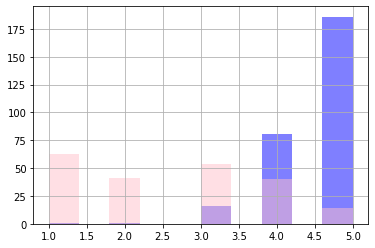

In [25]:
#Threshold Analysis: Pure Stars
temp=pd_dev  
temp[temp['label']==0]['stars'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['stars'].hist(bins=10,color='pink',alpha=0.5);

As shown in the threshold analysis here, it is understood that if reviews have a star lower than 2, it is very likely to
contain complaint/suggestion. And for those whose star is higher than five, it is probably a review without complaints/suggestion. Therefore, we create two labeling functions based on 
this observation.

In [26]:
############ CHECK IF WE CAN REMOVE THE IMPORTS HERE - WE DO IT ALSO IN THE WRAP-UP!!!!
######################
import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

@labeling_function()
def low_star(x):
    return POSITIVE if x.stars<=2 else ABSTAIN


@labeling_function()
def high_star(x):
    return NEGATIVE if x.stars==5 else ABSTAIN



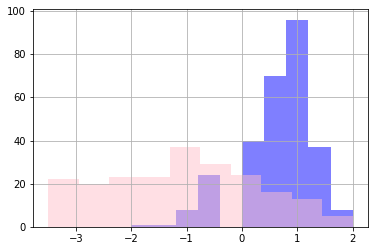

In [27]:
#Threshold Analysis: Higher or lower than business average
temp=pd_dev.merge(df_biz_stars, on= 'business_id', how='left')
temp['dif']= temp['stars_x']-temp['stars_y']
temp[temp['label']==0]['dif'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['dif'].hist(bins=10,color='pink',alpha=0.5);

The graph shows that if the review star is more than one star lower than the business star, then it's very likely 
than the review should be label as 1 whereas if it is higher than the business star, it is probably a review without
complaints or suggestions.

In [28]:
dict_biz_stars = dict(zip(df_biz_stars.business_id, df_biz_stars.stars))

@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def higher_than_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return NEGATIVE if a<x.stars  else ABSTAIN

@labeling_function(resources=dict(dict_biz_stars=dict_biz_stars))
def lower_than_biz(x,dict_biz_stars):
    if x.business_id!='#NAME?':
        a = dict_biz_stars[x.business_id]
    else:
        a = 0
    return POSITIVE if a>x.stars+1  else ABSTAIN

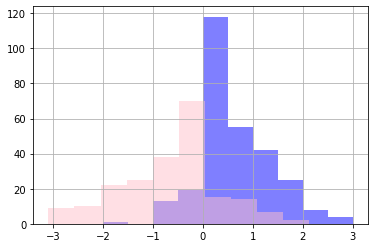

In [29]:
#Threshold Analysis: higher or lower than individual average
temp=pd_dev.merge(df_ind_stars, on= 'user_id', how='left')
temp['dif']= temp['stars']-temp['avg_stars']
temp[temp['label']==0]['dif'].hist(bins=10,color='blue',alpha=0.5);
temp[temp['label']==1]['dif'].hist(bins=10,color='pink',alpha=0.5);

The graph shows that if the review star is lower than the average user star, then it's very likely 
than the review should be label as 1 whereas if it is higher, it is probably a review without
complaints or suggestions.

In [30]:
com_info = zip(df_ind_stars.avg_stars, df_ind_stars.total_reviews)
dict_ind_stars = dict(zip(df_ind_stars.user_id, com_info ))
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def higher_than_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return NEGATIVE if (x.stars > a) else ABSTAIN

@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def lower_than_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if (x.stars < a) else ABSTAIN

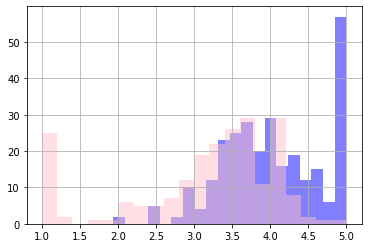

In [31]:
#Threshold Analysis: Picky individual
temp[temp['label']==0]['avg_stars'].hist(bins=20,color='blue',alpha=0.5);
temp[temp['label']==1]['avg_stars'].hist(bins=20,color='pink',alpha=0.5);

The graph shows that if the average review star is lower than 4.25, the review is more likely to be a complaint or suggestion.

In [32]:
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def picky_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            a = dict_ind_stars[x.user_id][0]
            b = dict_ind_stars[x.user_id][1]
        else:
            a = 0
            b = 0 
    else:
        a = 0
        b = 0
    return POSITIVE if a <4.25 else ABSTAIN

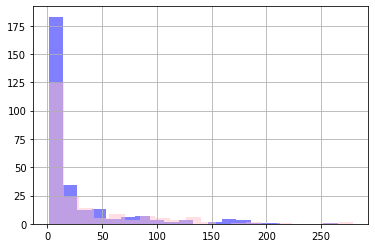

In [33]:
#Threshold Analysis: Talktive individual
temp[(temp['label']==0) & (temp['total_reviews']<300)]['total_reviews'].hist(bins=20,color='blue',alpha=0.5);
temp[(temp['label']==1)& (temp['total_reviews']<300)]['total_reviews'].hist(bins=20,color='pink',alpha=0.5);

In [34]:
@labeling_function(resources=dict(dict_ind_stars=dict_ind_stars))
def talktive_ind(x,dict_ind_stars):
    if x.user_id!='#NAME?':
        if x.user_id in dict_ind_stars.keys():
            b = dict_ind_stars[x.user_id][1]
        else:
            b = 0 
    else:
        b = 0
    return POSITIVE if b > 86  else ABSTAIN

In [35]:
#merge user_dev.jointime 
reduced_user = user_res.select('user_id','yelping_since')
reduced_user_pd= reduced_user.toPandas().drop_duplicates(subset=['user_id'])
reduced_user_pd['date']=reduced_user_pd['yelping_since'].map(lambda x:int(x[0:4]))
temp=pd_dev.merge(reduced_user_pd, on= 'user_id', how='left')

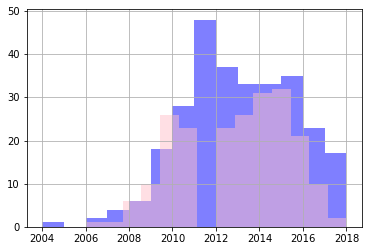

In [36]:
temp[temp['label']==0]['date_y'].hist(bins=14,color='blue',alpha=0.5);
temp[temp['label']==1]['date_y'].hist(bins=14,color='pink',alpha=0.5);

The graph shows that if the join year is 2011 or after 2016, the review is less likely to be a complaint or suggestion.

In [37]:
dict_user_date = dict(zip(reduced_user_pd.user_id, reduced_user_pd.date))
@labeling_function(resources=dict(dict_user_date=dict_user_date))
def date_ind(x,dict_user_date):
    if x.user_id!='#NAME?':
        if x.user_id in dict_user_date.keys():
            b = dict_user_date[x.user_id]
        else:
            b = 3000 
    else:
        b = 3000
    return NEGATIVE if (b==2011 or b>=2016)  else ABSTAIN

### 3.8 A wrap-up of all of Labelling Functions (LFs)
Below we define what will be the actual labels from our LF functions and then we run them all together so to compare their metrics:

In [38]:
#Try to apply Labeling function
import pyspark.sql.functions as F
from snorkel.labeling import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
import pandas as pd
import numpy as np
#from snorkel.labeling import ,LFAnalysis
from snorkel.labeling import LFAnalysis
from pyspark.sql import Row
from snorkel.labeling.lf import labeling_function
#from snorkel.labeling.lf.nlp_spark import spark_nlp_labeling_function
from snorkel.preprocess import preprocessor

ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

In [39]:
lfs = [
    #simon
    positive_percentage, review_false,
    #shuo
    keyword_love,keyword_great,keyword_rude,keyword_less,low_useful,high_useful, funny,
    #pavlos all 
    short_comment,long_comments,keyword_disgusting,keyword_cardboard,regex_home,
    Keyword_perfect,Keyword_avoid,keyword_bad,regex_over_coocked, Keyword_overpriced,key_good,
    #jiaqhi
    low_star,high_star,higher_than_biz,lower_than_biz,higher_than_ind,lower_than_ind,
    picky_ind,talktive_ind,date_ind
    ]
applier = SparkLFApplier(lfs)
L_dev = applier.apply(df_dev.rdd)
g_label =np.array(df_dev.select('label').collect())
LFAnalysis(L_dev, lfs).lf_summary(g_label)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 70.0 failed 1 times, most recent failure: Lost task 0.0 in stage 70.0 (TID 1083, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/spark.py", line 39, in map_fn
    return apply_lfs_to_data_point(*args, lfs=self._lfs, f_caller=f_caller)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 107, in apply_lfs_to_data_point
    y = f_caller(lf, x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 28, in __call__
    return f(x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/lf/core.py", line 77, in __call__
    return self._f(x, **self._resources)
  File "<ipython-input-21-9c68682efd7b>", line 6, in keyword_love
NameError: name 're' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/spark.py", line 39, in map_fn
    return apply_lfs_to_data_point(*args, lfs=self._lfs, f_caller=f_caller)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 107, in apply_lfs_to_data_point
    y = f_caller(lf, x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/apply/core.py", line 28, in __call__
    return f(x)
  File "/opt/anaconda/envs/Python3/lib/python3.6/site-packages/snorkel/labeling/lf/core.py", line 77, in __call__
    return self._f(x, **self._resources)
  File "<ipython-input-21-9c68682efd7b>", line 6, in keyword_love
NameError: name 're' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


Overall, we made 28 labelling functions based on keywords, heuristics and features. We chose the 20 LFs with the highest coverage that had at least 60% accuracy.

In [ ]:
# Top 20 LFs
lfs = [keyword_love,keyword_great,keyword_rude,keyword_less,low_useful,high_useful, funny,
    short_comment,long_comments,Keyword_perfect,keyword_bad,low_star,high_star,higher_than_biz,lower_than_biz,higher_than_ind,lower_than_ind,
    picky_ind,talktive_ind,date_ind]

applier = SparkLFApplier(lfs)
L_dev = applier.apply(df_dev.rdd)
g_label =np.array(df_dev.select('label').collect())
LFAnalysis(L_dev, lfs).lf_summary(g_label)

### 3.9 Choosing the LFs
Overall, we made 28 labelling functions based on keywords, heuristics and features. We chose the 20 LFs with the highest coverage that have accuracy  greater than 50%

In [ ]:
# lfs = [positive_percentage, review_false,keyword_love,keyword_great,keyword_rude,keyword_less,low_useful,high_useful, funny,
#     short_comment,long_comments,Keyword_perfect,keyword_bad,low_star,high_star,higher_than_biz,lower_than_biz,higher_than_ind,lower_than_ind,
#     picky_ind,talktive_ind,date_ind]

applier = SparkLFApplier(lfs)
L_dev = applier.apply(df_dev.rdd)
g_label =np.array(df_dev.select('label').collect())
LFAnalysis(L_dev, lfs).lf_summary(g_label)

### 3.10 Evaluating our LFs on the test set

After we developed and chose our LFs we must evaluate their performance on the test set. To do that we must convert our LFs into a single noise aware probabilistic label per data point. For our baseline approach we will use a simple majority vote on each data point. If the majority of the LFs vote complaint (1) then we label the data point as complaint and if the majority of LFs vote for no coplaint(0) then we label the data point as no coplaint

In [ ]:
#Import validation set to test how well our labelling functions work.
df_dev_valid = spark.read.csv("/project/EXPROTS/df_test.csv", escape='"', multiLine=True,
     inferSchema=True, header=True)

df_dev_valid= df_dev_valid.withColumnRenamed("label\r", "label")


In [ ]:
# df_train_final = spark.read.csv("/project/review_train_final.csv", escape='"', multiLine=True,
#      inferSchema=True, header=True)
# df_train_final= df_train_final.withColumnRenamed("label\r", "label")

# DATAFRAME review_train
normalized_data_dev_valid = pipeline_normalize.fit(df_dev_valid).transform(df_dev_valid)
normalized_data_dev_valid = pipeline_sentiment.fit(normalized_data_dev_valid).transform(normalized_data_dev_valid) 

#here we convert the cleantokens from a list to a string line (juct in case we need it later)
from pyspark.sql.functions import concat_ws
normalized_data_dev_valid = normalized_data_dev_valid.withColumn("cleanTokens_n", concat_ws(",", "cleanTokens"))
normalized_data_dev_valid = normalized_data_dev_valid.withColumn('n_clean_tokens', F.expr('size(cleanTokens)'))


pipeline = PretrainedPipeline("analyze_sentiment", lang="en") #is a pretrained pipeline; we do not need to define steps
sentiment_data_dev_valid = pipeline.annotate(normalized_data_dev_valid, column='text')
 

from pyspark.sql import functions as F
sentiment_data_dev_valid = sentiment_data_dev_valid.withColumn('pos_cnt', F.expr('size(filter(sentiment.result, x -> x in ("positive")))'))
sentiment_data_dev_valid = sentiment_data_dev_valid.withColumn('neg_cnt', F.expr('size(filter(sentiment.result, x -> x in ("negative")))'))
sentiment_data_dev_valid = sentiment_data_dev_valid.withColumn("pos_prc", sentiment_data_dev_valid["pos_cnt"]/(sentiment_data_dev_valid["pos_cnt"]+sentiment_data_dev_valid["neg_cnt"])).fillna(0)

df_dev_valid=sentiment_data_dev_valid
df_dev_valid.show()

However, using the majority vote may result in some signals being overrepresented. For example, we have the low_star and lower_than_ind which may be highly correlated. To deal with this issue Snorkel has a more appropriate labelling model that combines the outputs which can be imported from snorkel as LabelModel

In [ ]:
# Majority vote
from snorkel.labeling import MajorityLabelVoter
applier = SparkLFApplier(lfs)
L_dev_valid = applier.apply(df_dev_valid.rdd)
g_label_valid =np.array(df_dev_valid.select('label').collect())
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_dev_valid)

In [ ]:
# label Model
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_dev_valid, n_epochs=500, log_freq=100, seed=123)

In [ ]:
# Majorty vote accuracy
majority_acc = majority_model.score(L=L_dev_valid, Y=g_label_valid, tie_break_policy="random")[
    "accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")


# Label Model accuracy
label_model_acc = label_model.score(L=L_dev_valid, Y=g_label_valid, tie_break_policy="random")[
    "accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

We compare the two approaches on the validation split. The accuracy score with the majority vote is slightly lower compared to the label_model

### 3.11 Apply the LFs on the train test.
Since the Label Model proved to be more accurate in the validation set, we proceede with that to label the training set that will be used later in the pipeline to train the classifier. We follow the same NLP pipeline as before to create the features of sentimen analysis on the train set.

In [ ]:
# df_train_final = spark.read.csv("/project/review_train_final.csv", escape='"', multiLine=True,
#      inferSchema=True, header=True)
# df_train_final= df_train_final.withColumnRenamed("label\r", "label")

# DATAFRAME review_train
normalized_data_train = pipeline_normalize.fit(review_train).transform(review_train)
normalized_data_train = pipeline_sentiment.fit(normalized_data_train).transform(normalized_data_train) 

#here we convert the cleantokens from a list to a string line (juct in case we need it later)
from pyspark.sql.functions import concat_ws
normalized_data_train = normalized_data_train.withColumn("cleanTokens_n", concat_ws(",", "cleanTokens"))
normalized_data_train = normalized_data_train.withColumn('n_clean_tokens', F.expr('size(cleanTokens)'))


pipeline = PretrainedPipeline("analyze_sentiment", lang="en") #is a pretrained pipeline; we do not need to define steps
sentiment_data_train = pipeline.annotate(normalized_data_train, column='text')
 

from pyspark.sql import functions as F
sentiment_data_train = sentiment_data_train.withColumn('pos_cnt', F.expr('size(filter(sentiment.result, x -> x in ("positive")))'))
sentiment_data_train = sentiment_data_train.withColumn('neg_cnt', F.expr('size(filter(sentiment.result, x -> x in ("negative")))'))
sentiment_data_train = sentiment_data_train.withColumn("pos_prc", sentiment_data_train["pos_cnt"]/(sentiment_data_train["pos_cnt"]+sentiment_data_train["neg_cnt"])).fillna(0)

review_train=sentiment_data_train
review_train.show()

<br>
Now we will apply the LFs to get the label matrices. This task can be easily executed using the  Pandas Applier which has an easy and familiar interface. However, Pandas are less optimized for scale. Therefore, we decided to apply the LFs using SparkLFApplier that is more appropriate and efficient for larger datasets.
<br>

In [ ]:
applier = SparkLFApplier(lfs)
L_train = applier.apply(review_train.rdd)

label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)


### 3.12 Convert the probabilities to prediction
In this make the predictions for the train set, based on the probability that they have gained from the previous step:

In [ ]:
from snorkel.utils import probs_to_preds

probs_train = label_model.predict_proba(L_train)
preds_train = probs_to_preds(probs_train)

### 3.13 Filter unlabelled data 

 Some of the data points cannot be labelled by any of our LFs. Therefore, these labels embody no  supervision signal. A good practise is to filter these data points out before the training phase as they tend to hurt the performance of the classifier. Snorkel can deal with this issue easily

In [ ]:
from snorkel.labeling import filter_unlabeled_dataframe

review_train = review_train.toPandas()

probs_train = label_model.predict_proba(L_train)
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=review_train, y=probs_train, L=L_train
)

### 3.14 Create the final  filtered train set data frame 
Below we create our final train dataset which is going to be used in the next steps of our project.

In [ ]:
# Turn the probabilities into labels
preds_train = probs_to_preds(probs_train)
preds_train
#Form the final filtered train data frame
df_train_filtered['label'] = preds_train.tolist()
df_train_filtered=df_train_filtered.drop("_c0",axis=1)

#df_train_filtered.to_csv('EXPROTS/df_train_filtered.csv',header = 'true')
df_train_filtered.head(2)


## 4. Data Augmentation

 After we label the training set programmatically using LFs through Snorkel, we aim to augment the labelled training set using transformation functions (TFs). The aim of augmentation is to increase the size of the labelled training set by creating transformed copies of original data points. The transformation is class-preserving and is dictated by the user-defined TFs.
 Below we load the required packages to perform this:

In [ ]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
pip install utils-py

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from snorkel.augmentation import transformation_function
import spacy
from snorkel.preprocess.nlp import SpacyPreprocessor
import en_core_web_sm
nlp = en_core_web_sm.load()
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)
from snorkel.augmentation import RandomPolicy
nltk.download("wordnet")

## 4.1 Define Transformation Functions

TFs are functions that make minor alterations to the original data and create valid new data points of the original class.
In our dataset, we use text as one of the main sources of information for labelling. Therefore, we use the transformation_function decorator from Snorkel to define TFs that will return a slightly modified version of the original text. If the TFs cannot be applied to a datapoint the function returns nothing.
The transformation_function decorator takes an argument pre for pre-processor. We specify a SpacyPeprossessor for the augmentation task.
We defined four TFs that are listed below:

We replace verbs, nouns and adjectives with a synonym <br>
1.)	replace_verb_with_synonym:<br>
2.)	replace_noun_with_synonym<br>
3.)	replace_adjective_with_synonym<br>
<br>
we change the position of adjectives in the text.<br>
4.)	swap_adjectives:


In [ ]:
#Define TFs

def get_synonym(word, pos=None):
    """Get synonym for word given its part-of-speech (pos)."""
    synsets = wn.synsets(word, pos=pos)
    # Return None if wordnet has no synsets (synonym sets) for this word and pos.
    if synsets:
        words = [lemma.name() for lemma in synsets[0].lemmas()]
        if words[0].lower() != word.lower():  # Skip if synonym is same as word.
            # Multi word synonyms in wordnet use '_' as a separator e.g. reckon_with. Replace it with space.
            return words[0].replace("_", " ")
        
def replace_token(spacy_doc, idx, replacement):
    """Replace token in position idx with replacement."""
    return " ".join([spacy_doc[:idx].text, replacement, spacy_doc[1 + idx :].text])

@transformation_function(pre=[spacy])
def replace_verb_with_synonym(x):
    # Get indices of verb tokens in sentence.
    verb_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "VERB"]
    if verb_idxs:
        # Pick random verb idx to replace.
        idx = np.random.choice(verb_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="v")
        # If there's a valid verb synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x
        
@transformation_function(pre=[spacy])
def replace_noun_with_synonym(x):
    # Get indices of noun tokens in sentence.
    noun_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "NOUN"]
    if noun_idxs:
        # Pick random noun idx to replace.
        idx = np.random.choice(noun_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="n")
        # If there's a valid noun synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x


@transformation_function(pre=[spacy])
def replace_adjective_with_synonym(x):
    # Get indices of adjective tokens in sentence.
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    if adjective_idxs:
        # Pick random adjective idx to replace.
        idx = np.random.choice(adjective_idxs)
        synonym = get_synonym(x.doc[idx].text, pos="a")
        # If there's a valid adjective synonym, replace it. Otherwise, return None.
        if synonym:
            x.text = replace_token(x.doc, idx, synonym)
            return x
@transformation_function(pre=[spacy])      
def swap_adjectives(x):
    adjective_idxs = [i for i, token in enumerate(x.doc) if token.pos_ == "ADJ"]
    # Check that there are at least two adjectives to swap.
    if len(adjective_idxs) >= 2:
        idx1, idx2 = sorted(np.random.choice(adjective_idxs, 2, replace=False))
        # Swap tokens in positions idx1 and idx2.
        x.text = " ".join(
            [
                x.doc[:idx1].text,
                x.doc[idx2].text,
                x.doc[1 + idx1 : idx2].text,
                x.doc[idx1].text,
                x.doc[1 + idx2 :].text,
            ]
        )
        return x
    
tfs = [replace_verb_with_synonym,
       replace_noun_with_synonym,
       replace_adjective_with_synonym,
       swap_adjectives]

## 4.2 Apply Transformation Functions

We define a Random Policy that randomly picks the sequence of TFs to be applied on each data point. We define the number of TFs to be applied on each data point to be 2 by setting sequence_length=2 and the number of transformed data points per original point to be 2 by setting n_per_original =2.

In [ ]:
from snorkel.augmentation import RandomPolicy

random_policy = RandomPolicy(
    len(tfs), sequence_length=2, n_per_original=2, keep_original=True
)

In [ ]:
# We convert it back to pandas to execute the augmentation.
from snorkel.augmentation import PandasTFApplier
tf_applier = PandasTFApplier(tfs,random_policy)

# Apply the TFs on the train set
df_train_augmented = tf_applier.apply(df_train_filtered)
Y_train_augmented = df_train_augmented["label"].values

print(f"Original training set size: {df_train_filtered.size}")
print(f"Augmented training set size: {df_train_augmented.size}")

#df_train_augmented.to_csv('EXPROTS/df_train_augmented.csv',header = 'true')

# 5. Training Binary Classifier

## 5.1  Feature Engineering:

Before we can fit our data into the classification model, we need to transform our data, especially for the Text data.
The necessary steps include tokenization, removing stop words and countvectorization. First step is tokenization, through
which we can break down the sentences into tokens enabling others to calculate the frequency of each word, which is one popular 
way to represent the sentence. But before that, we need to remove the stopwords (such as is, am, an) from the tokens to clean up 
the noises. Finally we use the countvectorizer to converts text to vectors which give information of token counts such that we can
leverage the information of text into the classification models.

In [118]:
df_dev.fillna(0,inplace=True)

In [119]:
#pipeline 1 select columns
col_list= ['cool','funny', 'stars', 'text', 'useful', 'label']
def select_col(df,col_list):
    return df[col_list]  
df_train = select_col(df_train,col_list)
df_dev = select_col(df_dev,col_list)
df_test = select_col(df_test,col_list)
df_aug = select_col(df_aug,col_list)

In [120]:
Y_train=df_train.label
Y_dev=df_dev.label
Y_test=df_test.label
Y_aug=df_aug.label

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_text = vectorizer.fit_transform(df_train.text.tolist())

X_dev_text = vectorizer.transform(df_dev.text.tolist())
X_test_text = vectorizer.transform(df_test.text.tolist())
X_aug_text = vectorizer.transform(df_aug.text.tolist())


In [122]:
x_train_num.shape

X_train_text.shape

(2500, 124580)

## 5.3 Training the Classifiers

In [123]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Function that outputs model results and metrics
def model_results(y_test,y_pred,y_train,y_pred_train):
    cm = confusion_matrix(y_test,y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
# labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not succesful', 'succesful']); ax.yaxis.set_ticklabels(['Not succesful', 'Succesful'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);    
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print("AUC Score: "+ str(roc_auc_score(y_test, y_pred)))
    print("Accuracy on Test Set: "+ str(accuracy_score(y_test, y_pred)*100)+"%")
    print("Accuracy on Train Set: "+ str(accuracy_score(y_train, y_pred_train)*100)+"%")

### 5.3.1 Logistic Regression

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       312
           1       0.76      0.76      0.76       182

    accuracy                           0.82       494
   macro avg       0.81      0.81      0.81       494
weighted avg       0.82      0.82      0.82       494

AUC Score: 0.8102106227106227
Accuracy on Test Set: 82.38866396761134%
Accuracy on Train Set: 100.0%


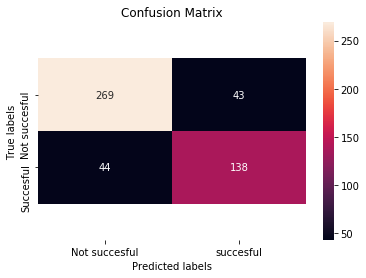

In [124]:
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression
lr = LogisticRegression(random_state = 123)

# Fit it on train set
lrfit = lr.fit(X_train_text, Y_train)

# Predict on test set
y_pred = lrfit.predict(X_test_text)

# Predict on train set
y_pred_train = lrfit.predict(X_train_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_train,y_pred_train)

### 5.3.2 Decision Tree Classifier

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       312
           1       0.60      0.51      0.55       182

    accuracy                           0.69       494
   macro avg       0.67      0.65      0.66       494
weighted avg       0.69      0.69      0.69       494

AUC Score: 0.6549908424908425
Accuracy on Test Set: 69.4331983805668%
Accuracy on Train Set: 71.96000000000001%


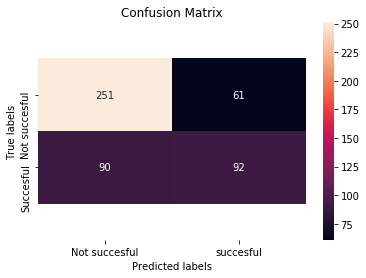

In [62]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth = 5, random_state = 123)

# Train Decision Tree Classifer
#clfit = 
clfit = clf.fit(X_train_text, Y_train)

#Predict the response for test dataset
y_pred = clfit.predict(X_test_text)

# Predict on train
y_pred_train = clfit.predict(X_train_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_train,y_pred_train)

### 5.3.3 Random Forest Classifier

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       312
           1       0.68      0.45      0.54       182

    accuracy                           0.72       494
   macro avg       0.70      0.66      0.67       494
weighted avg       0.71      0.72      0.70       494

AUC Score: 0.6600274725274725
Accuracy on Test Set: 71.65991902834008%
Accuracy on Train Set: 98.08%


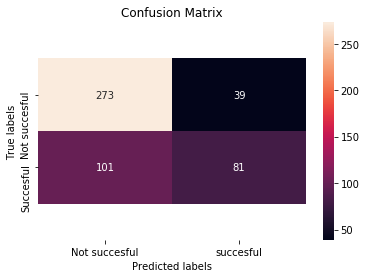

In [63]:
from sklearn.ensemble import RandomForestClassifier 

# Create Decision Tree classifer object
rf = RandomForestClassifier(random_state = 123)

# Train Decision Tree Classifer
#clfit = 
rfit = rf.fit(X_train_text, Y_train)

#Predict the response for test dataset
y_pred = rfit.predict(X_test_text)

# Predict on train
y_pred_train = rfit.predict(X_train_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_train,y_pred_train)



It is clear that out of the three classifiers, logistic regression has the better performance in our train text data. Thus, we will be proceeding to apply logistic regression to the development set and the augmented set to be able to draw comparisons. All the trained models will be validated with the same test set.

## 5.4 Applying the best model on Other Sets

### 5.4.1 Augmented Set

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       312
           1       0.76      0.77      0.77       182

    accuracy                           0.83       494
   macro avg       0.81      0.82      0.82       494
weighted avg       0.83      0.83      0.83       494

AUC Score: 0.816849816849817
Accuracy on Test Set: 82.79352226720647%
Accuracy on Train Set: 100.0%


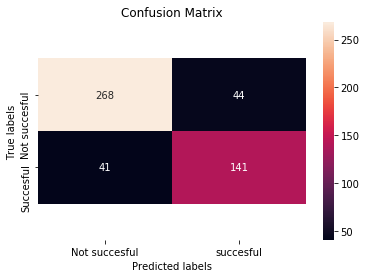

In [64]:
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression
lr = LogisticRegression(random_state = 123)

# Fit it on train set
lrfit = lr.fit(X_aug_text, Y_aug)

# Predict on test set
y_pred = lrfit.predict(X_test_text)

# Predict on train set
y_pred_train = lrfit.predict(X_aug_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_aug,y_pred_train)

### 5.4.2 Development Set

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       312
           1       0.77      0.71      0.74       182

    accuracy                           0.82       494
   macro avg       0.81      0.80      0.80       494
weighted avg       0.82      0.82      0.82       494

AUC Score: 0.7962454212454213
Accuracy on Test Set: 81.78137651821862%
Accuracy on Train Set: 100.0%


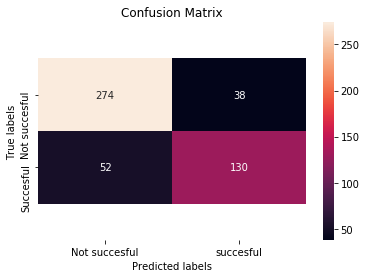

In [125]:
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression
lr = LogisticRegression(random_state = 123)

# Fit it on train set
lrfit = lr.fit(X_dev_text, Y_dev)

# Predict on test set
y_pred = lrfit.predict(X_test_text)

# Predict on train set
y_pred_train = lrfit.predict(X_dev_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_dev,y_pred_train)

As you can see from the results, the augmented dataset performed slightly better than the original weakly labelled train dataset. This shows that our approach of data augmentation was successful and it has led us to higher predictive power in our model. Also the development set has yielded slightly lower results than the train set and the augmented set. That is good news as it means that our weak labeling approach has worked perfectltly and it assisted us to generate more data points and higher AUC score and Accuracy.

In [118]:
df_dev.fillna(0,inplace=True)

#pipeline 1 select columns
col_list= ['cool','funny', 'stars', 'text', 'useful', 'label']
def select_col(df,col_list):
    return df[col_list]  
df_train = select_col(df_train,col_list)
df_dev = select_col(df_dev,col_list)
df_test = select_col(df_test,col_list)
df_aug = select_col(df_aug,col_list)

Y_train=df_train.label
Y_dev=df_dev.label
Y_test=df_test.label
Y_aug=df_aug.label

# 5. Training Binary Classifier

## 5.1  Feature Engineering:

Before we can fit our data into the classification model, we need to transform our data, especially for the Text data.
The necessary steps include tokenization, removing stop words and countvectorization. First step is tokenization, through
which we can break down the sentences into tokens enabling others to calculate the frequency of each word, which is one popular 
way to represent the sentence. But before that, we need to remove the stopwords (such as is, am, an) from the tokens to clean up 
the noises. Finally we use the countvectorizer to converts text to vectors which give information of token counts such that we can
leverage the information of text into the classification models.

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_text = vectorizer.fit_transform(df_train.text.tolist())

X_dev_text = vectorizer.transform(df_dev.text.tolist())
X_test_text = vectorizer.transform(df_test.text.tolist())
X_aug_text = vectorizer.transform(df_aug.text.tolist())


x_train_num.shape

X_train_text.shape

## 5.3 Training the Classifiers

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Function that outputs model results and metrics
def model_results(y_test,y_pred,y_train,y_pred_train):
    cm = confusion_matrix(y_test,y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
# labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Not succesful', 'succesful']); ax.yaxis.set_ticklabels(['Not succesful', 'Succesful'])
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);    
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print("AUC Score: "+ str(roc_auc_score(y_test, y_pred)))
    print("Accuracy on Test Set: "+ str(accuracy_score(y_test, y_pred)*100)+"%")
    print("Accuracy on Train Set: "+ str(accuracy_score(y_train, y_pred_train)*100)+"%")

### 5.3.1 Logistic Regression

from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression
lr = LogisticRegression(random_state = 123)

# Fit it on train set
lrfit = lr.fit(X_train_text, Y_train)

# Predict on test set
y_pred = lrfit.predict(X_test_text)

# Predict on train set
y_pred_train = lrfit.predict(X_train_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_train,y_pred_train)

### 5.3.2 Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth = 5, random_state = 123)

# Train Decision Tree Classifer
#clfit = 
clfit = clf.fit(X_train_text, Y_train)

#Predict the response for test dataset
y_pred = clfit.predict(X_test_text)

# Predict on train
y_pred_train = clfit.predict(X_train_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_train,y_pred_train)

### 5.3.3 Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier 

# Create Decision Tree classifer object
rf = RandomForestClassifier(random_state = 123)

# Train Decision Tree Classifer
#clfit = 
rfit = rf.fit(X_train_text, Y_train)

#Predict the response for test dataset
y_pred = rfit.predict(X_test_text)

# Predict on train
y_pred_train = rfit.predict(X_train_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_train,y_pred_train)



It is clear that out of the three classifiers, logistic regression has the better performance in our train text data. Thus, we will be proceeding to apply logistic regression to the development set and the augmented set to be able to draw comparisons. All the trained models will be validated with the same test set.

## 5.4 Applying the best model on Other Sets

### 5.4.1 Augmented Set

from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression
lr = LogisticRegression(random_state = 123)

# Fit it on train set
lrfit = lr.fit(X_aug_text, Y_aug)

# Predict on test set
y_pred = lrfit.predict(X_test_text)

# Predict on train set
y_pred_train = lrfit.predict(X_aug_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_aug,y_pred_train)

### 5.4.2 Development Set

from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression
lr = LogisticRegression(random_state = 123)

# Fit it on train set
lrfit = lr.fit(X_dev_text, Y_dev)

# Predict on test set
y_pred = lrfit.predict(X_test_text)

# Predict on train set
y_pred_train = lrfit.predict(X_dev_text)

# Get Results and metrics
model_results(Y_test,y_pred,Y_dev,y_pred_train)

As you can see from the results, the augmented dataset performed slightly better than the original weakly labelled train dataset. This shows that our approach of data augmentation was successful and it has led us to higher predictive power in our model. Also the development set has yielded slightly lower results than the train set and the augmented set. That is good news as it means that our weak labeling approach has worked perfectltly and it assisted us to generate more data points and higher AUC score and Accuracy.

df_dev.fillna(0,inplace=True)

In [119]:
#pipeline 1 select columns
col_list= ['cool','funny', 'stars', 'text', 'useful', 'label']
def select_col(df,col_list):
    return df[col_list]  
df_train = select_col(df_train,col_list)
df_dev = select_col(df_dev,col_list)
df_test = select_col(df_test,col_list)
df_aug = select_col(df_aug,col_list)

In [120]:
Y_train=df_train.label
Y_dev=df_dev.label
Y_test=df_test.label
Y_aug=df_aug.label

## 6. Conclusion

## 6.1 Summary

Through Section 2 to Section 5, we have demonstrated a complete pipeline for a weak supervised learning project, including data extraction (loading data), data transformation (filtering, etc), mannual labeling, create labeling function, data augmentation and train classifers (within each another round of data transformation is done). Throughout the steps, we sought to apply scalable tools which makes it transferable to an industrial scale. 

By applying the various labeling functions ranging from NLP-based functions to numeric-based functions and data augmentation to the unlabeled dataset, we obtained the weak label for each datapoint and make more training data available for the classifier. In our case, by this method, we **continue** after seeing the result. 

## 6.2 Limitations

1. The major limitation of our work is resource and most significant example is that because the limited resource we can't host all of our json files on the NoSQL database that we created. 
2. The use of a single cluster did not allow have bigger subsets for training. Furthermore the training of LFs, took long because of this.
3. Limited documentantion regarding Apache Spark; Most of it is written in Scala only


# Appendix
## Minutes


Meeting 1 
Date: 16/02/2020
Meeting no.: 
Duration: 1 hours
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
We reviewed the lectures’ references
We summarized on which documents our project should be based to
We exchanged secondary resources, ideas about the project
Goals for next meeting:
Find datasets for our project


Meeting 2 
Date: 18/02/2020
Duration: 2 hours
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
·   	Discussed about the datasets and finally agreed on Yelp dataset. 
·   	Listed the priority tasks that we should do in the following weeks
·   	Divided the tasks properly to every group member
Goals for next meeting:
·   	Create the environment  
·   	Allowing utilisation of Spark on Faculty


Meeting 3 
Date: 22/02/2020
Duration: 1 hour
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo (all via hangout)
Summary:
Up to this meeting, group decided to delay the stage of selecting a dataset as it has been agreed that it is of vital importance for the successful completion of the project. Individually everyone reviewed the coursework brief to have a better idea of what kind of dataset we should look for.
All the members made their dataset proposals on the following doc:
https://docs.google.com/document/d/1bbV36BvMWWAGWH7uwurNrEbfJkMzonA1jF6cMbHkjzs/edit?usp=sharing
In our meeting:
Jiaqi together with Simon noted down important points from the coursework brief.
Members discussed the requirements and if the proposed datasets can fulfill them.
Team decided to extend the research for a dataset as only the yelp dataset fulfills the requirements so far.
Simon proposed to check for cases-datasets from Azure AI gallery
Goals for next meeting:
Continue the research for a transactional dataset. Which has many attributes and does not rely only on text data.
Next meeting will be held shortly for our final decision regarding the dataset.


Meeting 4 
Date: 25/02/2020
Meeting no.: 
Duration: 2 hours
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
Simon elaborated his ideas regarding the Yelp Dataset. He recognized that the dataset may have been selected from other groups, however believes that the group should proceed with this one as it has a wealth of different attributes, transactional data and database schema. For the latter, he proposed that we can create a DB to host our files.
Group agreed to send a project proposal to Niall with the Yelp Proposal
Simon wrote the proposal, team members reviewed it. 
Goals for next meeting:
Wait for Niall’s response, search for further datasets



Meeting 5
Short Discussion with Niall about the project 
Date: 6/3/2020
Meeting no.: 
Duration: 30 minutes
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
Jiaqi approached Niall during the workshop to discuss the project
First question was about the output label (If positive/negative is appropriate)
Niall suggested that in our case, it will be tricky to be certain that a review is positive or negative only from the text.
Also, the rating of each review can be used in our labeling functions
Then Simon and Andreas had a long discussion with Niall about setting up the database for the project and it was concluded that we are going to set up a MongoDB database through CosmosDB of Azure.
After considering Niall’s suggestions about the label, Andreas suggested to label if a review includes a suggestion/complaint or not.
The rest of the team agreed and the meeting was adjourned.
Goals for next meeting:
Approach initial steps in setting up the database
Start introductory analysis with the dataset
Jiaqi will decide on how to split the data


 Meeting 6
Video Conference on Google Hangouts 
Date: 8/3/2020
Meeting no.: 6 
Duration: 2 hours
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
All members updated the team for their work
We discussed some issues to avoid the use of pandas completely
We expressed our ideas on potential improvements.
Goals for next meeting:
Jiaqi, Pavlos, Shuo will start to write LFs
Andreas, Simos to complete the GitHub set-up and creating the Cosmos DB.


Meeting 7 
Date: 10/3/2020
Meeting no.: 
Duration: 2 hours
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
We constructed a diagram illustrating the pipeline from start to finish
We made sure that everybody understands the procedure.
We decided to work on the LFs and the application of those to the train set
we discussed the procedure of augmentation
Some issues were raised regarding the application of the classifier using pyspark.
Goals for next meeting:
All the individual part to be completed
Everybody start with the write-up
resolve the issue with the classifier and the augmentation
Create a structured notebook where all members will enter their individual work


Meeting 8
Date: 12/3/2020
Meeting no.: 
Duration: Full-Time
Attendees: Andreas, Jiaqi, Pavlos, Symeon, Shuo
Summary:
We summarized all the analysis in two jupyter notebooks
We checked for inconsistencies
We resolved problems with mongo-db and classifier 
We proofread the analysis

